In [1]:
# Import numpy, pandas for data manipulation
import numpy as np
import pandas as pd

# Import matplotlib, seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import the data
weather_data = pd.read_csv('weather_data_test.csv',parse_dates=['datetime'], sep=';', decimal=','
                     , infer_datetime_format=True)

# Check the shape of the dataset
print(weather_data.shape)

# Select the datetime and the temperature columns
temp_df = weather_data[["datetime","T_mu"]]
temp_df.head(10)

(1346, 17)


,datetime,T_mu
0,2015-09-03,13.7375
1,2015-09-04,14.8250
2,2015-09-05,14.2750
3,2015-09-06,13.1250
4,2015-09-07,12.0875
5,2015-09-08,12.5375
6,2015-09-10,13.0625
7,2015-09-11,13.5375
8,2015-09-12,14.7500
9,2015-09-13,15.1375


In [2]:
# Check the shape of the dataset
temp_df.shape

(1346, 2)

In [3]:
# Select the subset data from 2016 to 2019
mask = (temp_df['datetime'] >= '2016-01-01') & (temp_df['datetime'] <= '2019-05-21')
temp_df = temp_df.loc[mask]

# Reset the index
temp_df.set_index("datetime", inplace=True)

# Inspect first 5 rows and last 5 rows of the data
from IPython.display import display
display(temp_df.head(5))
display(temp_df.tail(5))

,T_mu
datetime,
2016-01-01,-4.5500
2016-01-02,-7.0000
2016-01-03,-8.7375
2016-01-04,-11.1750
2016-01-05,-17.6250


,T_mu
datetime,
2019-05-17,13.783333
2019-05-18,15.508333
2019-05-19,16.595833
2019-05-20,17.258333
2019-05-21,18.433333


In [4]:
temp_df.describe()

,T_mu
count,1228.000000
mean,6.302811
std,8.433225
min,-22.675000
25%,0.559375
50%,5.227083
75%,13.784375
max,26.145833


In [5]:
# Output the maximum and minimum temperature date
print(temp_df.loc[temp_df["T_mu"] == temp_df["T_mu"].max()])
print(temp_df.loc[temp_df["T_mu"] == temp_df["T_mu"].min()])

                 T_mu
datetime             
2018-07-17  26.145833
              T_mu
datetime          
2016-01-07 -22.675


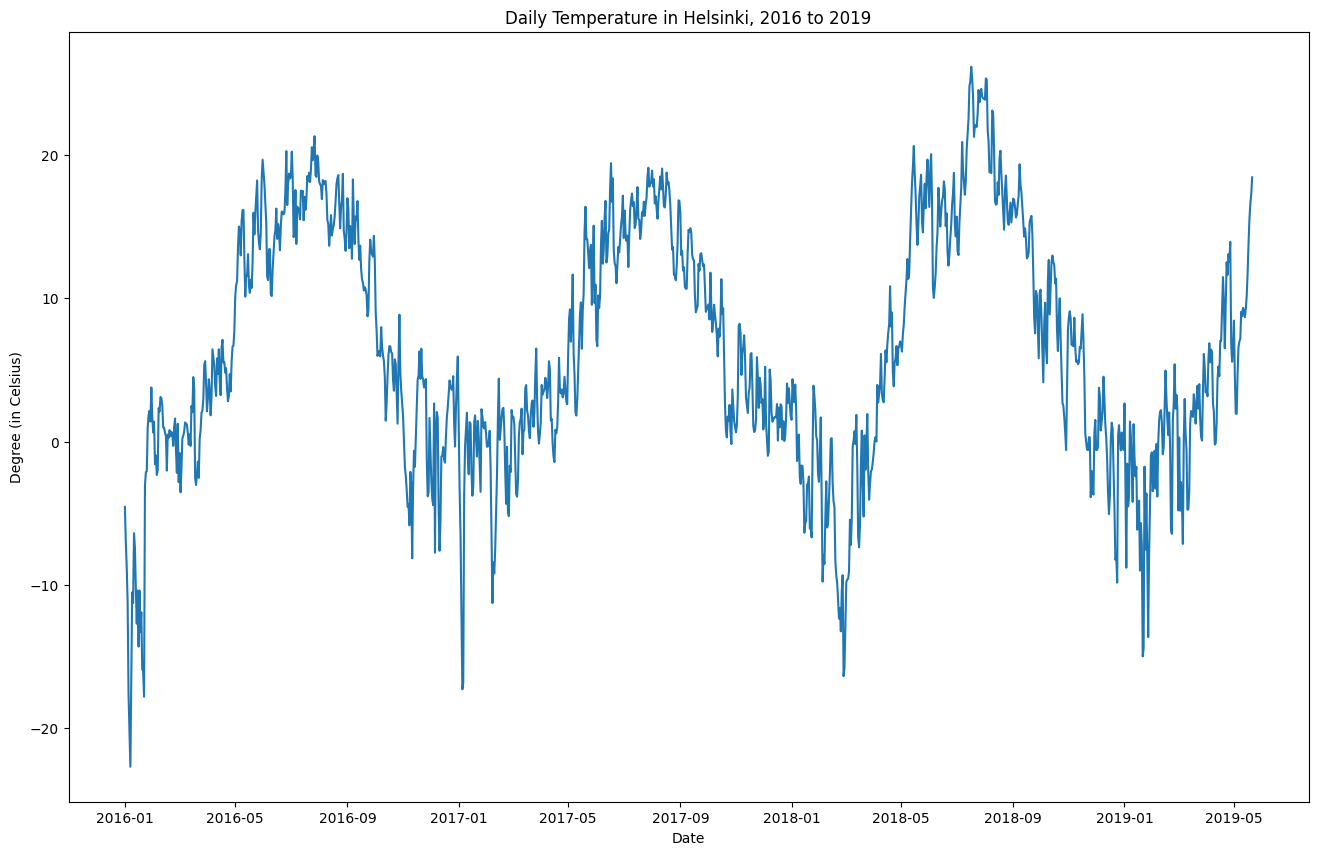

In [7]:
# Plot the daily temperature change
plt.figure(figsize=(16,10), dpi=100)
plt.plot(temp_df.index, temp_df.T_mu, color='tab:blue')
plt.gca().set(title="Daily Temperature in Helsinki, 2016 to 2019", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

<Axes: xlabel='datetime'>

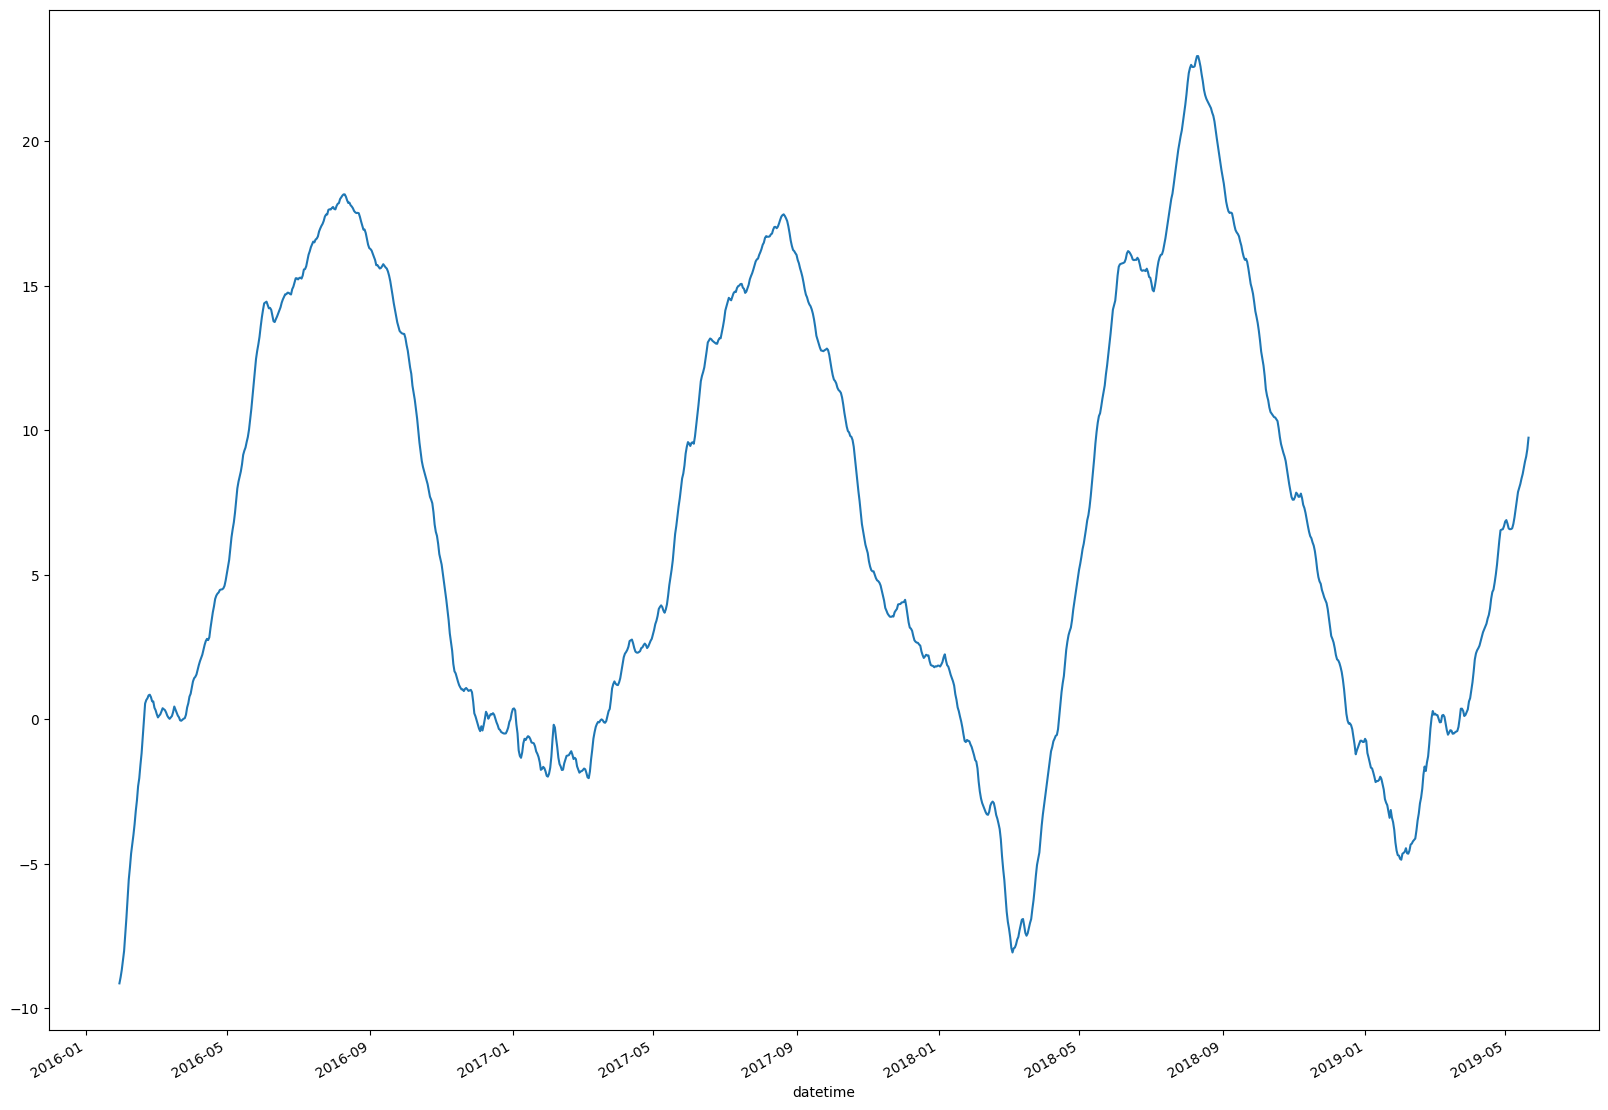

In [8]:
# Apply the Moving Average function by a subset of size 30 days.
temp_df_mean = temp_df.T_mu.rolling(window=30).mean()
temp_df_mean.plot(figsize=(20,15))

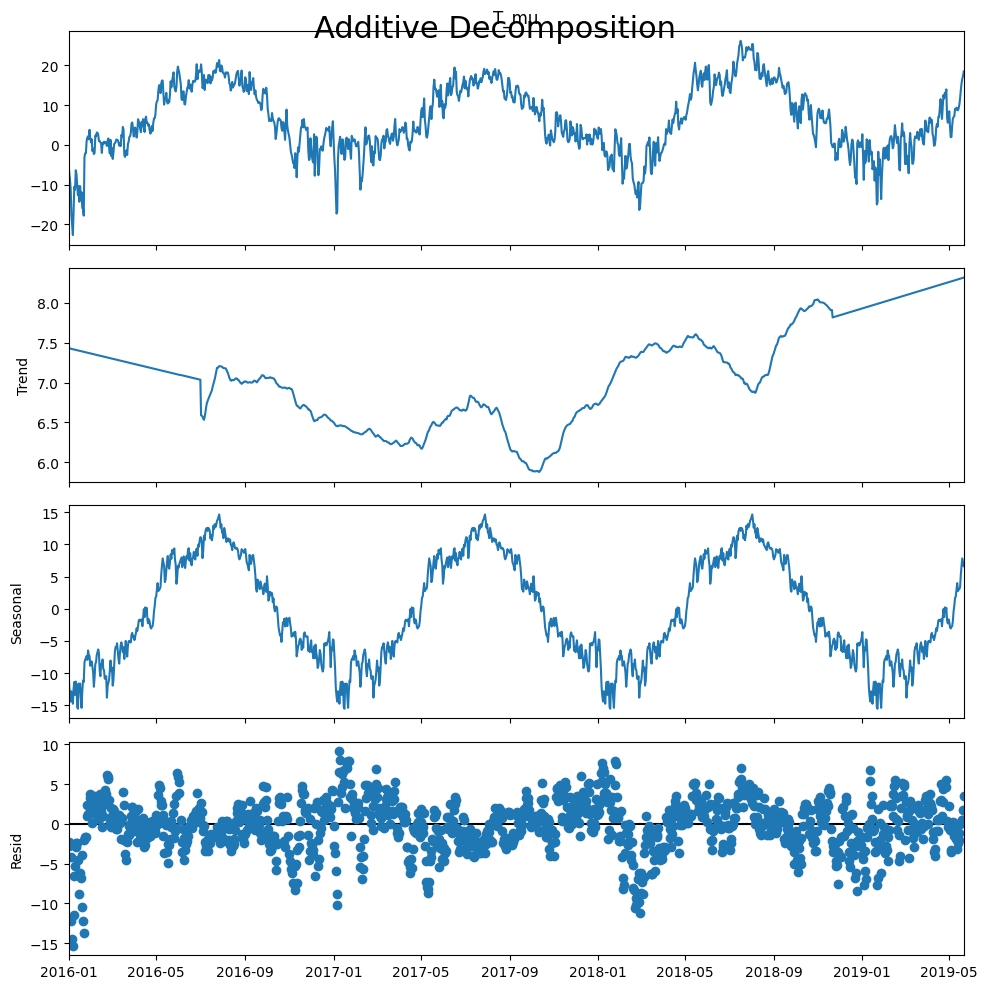

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(temp_df.T_mu, model='additive', extrapolate_trend='freq', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

In [10]:
# Shift the current temperature to the next day.
predicted_df = temp_df["T_mu"].to_frame().shift(1).rename(columns = {"T_mu": "T_mu_pred" })
actual_df = temp_df["T_mu"].to_frame().rename(columns = {"T_mu": "T_mu_actual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(5)

,T_mu_actual,T_mu_pred
datetime,,
2016-01-02,-7.0000,-4.5500
2016-01-03,-8.7375,-7.0000
2016-01-04,-11.1750,-8.7375
2016-01-05,-17.6250,-11.1750
2016-01-06,-20.2625,-17.6250


In [17]:

rmse = np.sqrt(((one_step_df.T_mu_actual - one_step_df.T_mu_pred) ** 2).mean())
print("The RMSE is",rmse)

The RMSE is 2.2618558244607696


Weather Forecast using SARIMA model

In [18]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [20]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [21]:
# Import the statsmodels library for using SARIMAX model
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

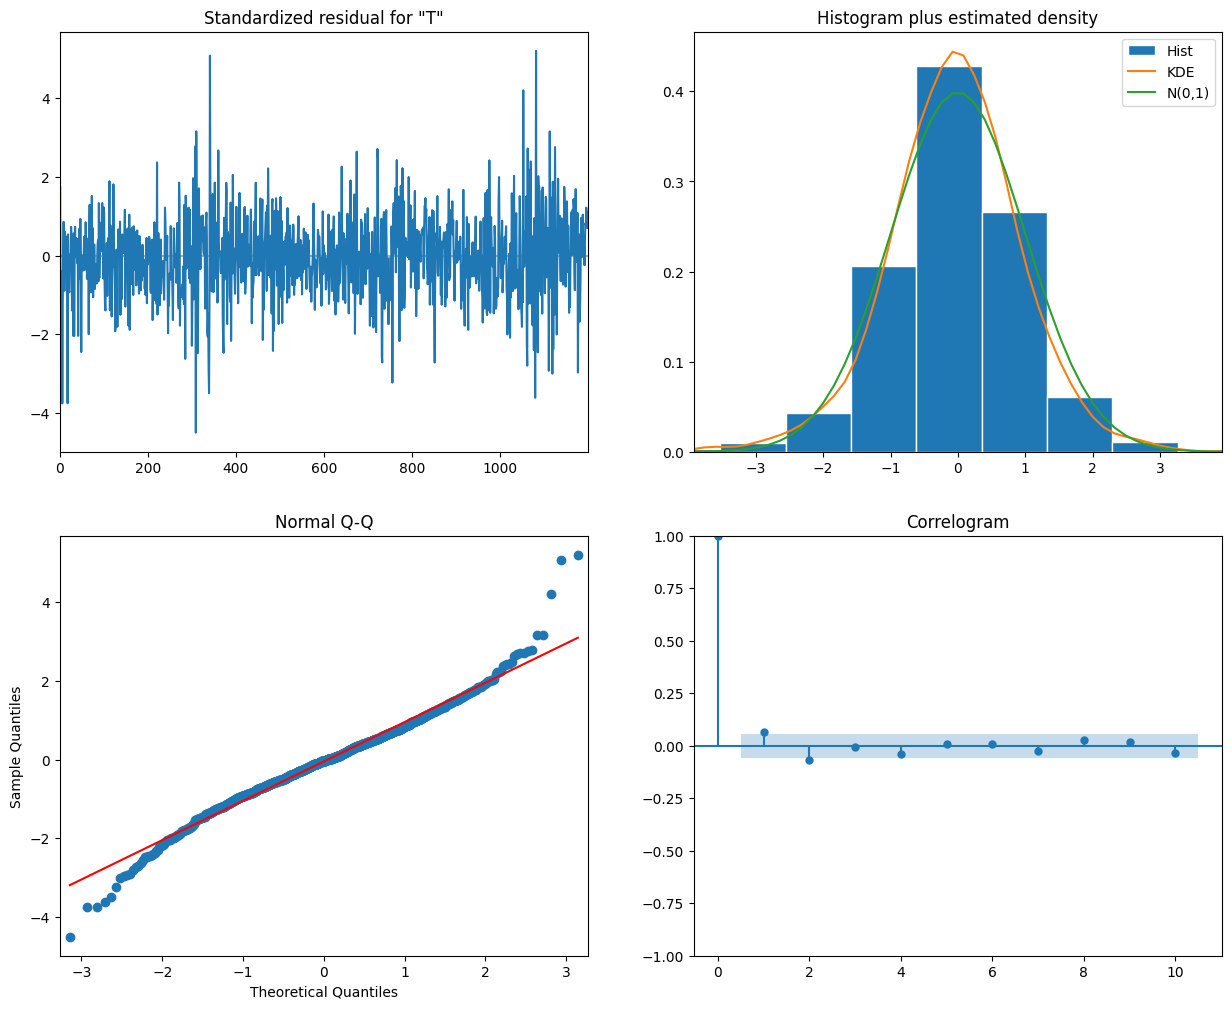

In [22]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [23]:
pred = results.get_prediction(start=pd.to_datetime('2017-05-19'), dynamic=False)
pred_ci = pred.conf_int()

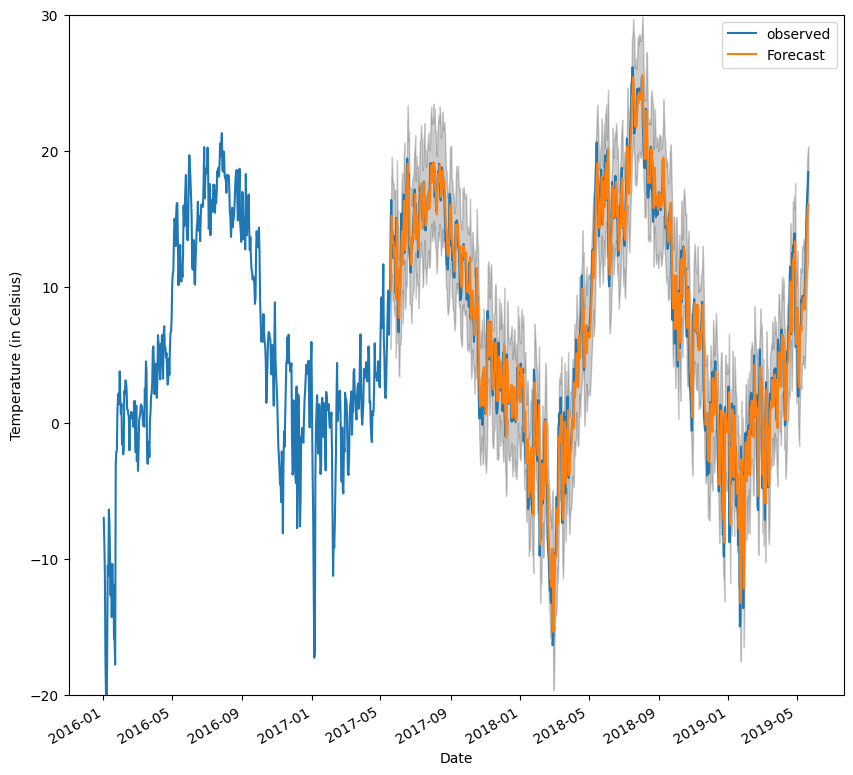

In [24]:
ax = one_step_df.T_mu_actual['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

In [29]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.T_mu_actual['2017-05-19':]
print(y_forecasted.shape)
print(y_truth.shape)
# Compute the mean square error

mse = ((y_truth - y_forecasted) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

(727,)
(727,)
The Mean Squared Error of our forecasts is 4.78


In [30]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-05-19'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

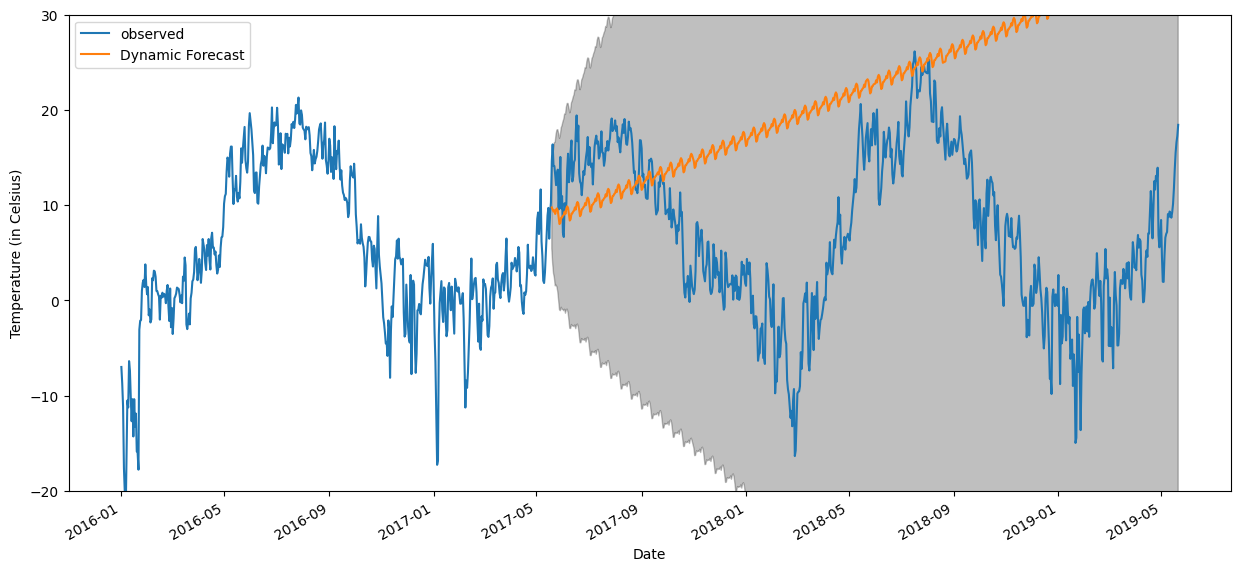

In [36]:
ax = one_step_df.T_mu_actual['2015':].plot(label='observed', figsize=(15, 7))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

In [37]:
  # Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = one_step_df.T_mu_actual['2017-05-19':]

# Compute the mean square error
mse = sqrt(((y_truth - y_forecasted) ** 2).mean())

print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 20.04
